In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse
from pathlib import Path
import re
import random
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Normalization across the whole dataset

### No normalization!

In [3]:
from pathlib import Path
import re, random, math, os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# Config
# =========================
SPLIT_DIR = r"/content/drive/MyDrive/CD/patient_data_clean_nozero_181920212223_1800_20%"
POS_PATIENTS = {1, 2, 16, 19, 21, 22, 25, 37, 39, 43, 44, 47, 50, 56, 58, 62, 65, 66, 73, 78}

BATCH_SIZE       = 3
EPOCHS           = 100
LR               = 1e-4
SEED             = 13
BEST_MODEL_PATH  = "best_keras_img_by_val_acc.h5"

# not used for dedup height; kept for reference
TARGET_H = 300

# =========================
# Noise config (train-time augmentation only)
# =========================
TRAIN_ADD_GAUSS_NOISE = True     # training generator only
TRAIN_NOISE_FRAC      = 0.10  # was 0.05    # noise std = noise_frac * sample_std (per item)
TRAIN_NOISE_PROB      = 1.0      # probability to apply noise to a sample
EPS_STD               = 1e-8

# =========================
# Repro
# =========================
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
for g in tf.config.list_physical_devices('GPU'):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

# =========================
# Helpers for ID/labels
# =========================
PATIENT_NUM_RX = re.compile(r'^ID(\d+)')
BASE_ID_RX     = re.compile(r'^(ID\d+(?:-\d+)?)')

def patient_num_from_path(pathlike):
    stem = Path(pathlike).stem
    m = PATIENT_NUM_RX.match(stem)
    return int(m.group(1)) if m else None

def base_id_from_path(pathlike):
    stem = Path(pathlike).stem
    m = BASE_ID_RX.match(stem)
    return m.group(1) if m else stem

def label_for_file(p: Path) -> int:
    pnum = patient_num_from_path(p)
    return 1 if (pnum is not None and pnum in POS_PATIENTS) else 0

# =========================
# List files & make ID-based splits (80/10/10 by ID)
# =========================
split_dir = Path(SPLIT_DIR)
all_csvs = sorted(split_dir.glob("*.csv"))
if not all_csvs:
    raise FileNotFoundError(f"No CSV found in {SPLIT_DIR}")

id_to_files = {}
for f in all_csvs:
    pid = patient_num_from_path(f)
    if pid is None:
        continue
    id_to_files.setdefault(pid, []).append(f)

all_ids = sorted(id_to_files.keys())
print('all_ids = ', all_ids)

id_labels = np.array([1 if pid in POS_PATIENTS else 0 for pid in all_ids], dtype=int)

ids_trainval, ids_test = train_test_split(
    all_ids, test_size=0.10, random_state=SEED, stratify=id_labels
)
labels_trainval = np.array([1 if pid in POS_PATIENTS else 0 for pid in ids_trainval], dtype=int)

ids_train, ids_val = train_test_split(
    ids_trainval, test_size=0.1111111, random_state=SEED, stratify=labels_trainval
)

train_files = [f for pid in ids_train for f in id_to_files[pid]]
val_files   = [f for pid in ids_val   for f in id_to_files[pid]]
test_files  = [f for pid in ids_test  for f in id_to_files[pid]]

def split_summary_by_ids(name, ids, files):
    ys = np.array([label_for_file(f) for f in files], dtype=int)
    print(f"{name:>6} | ids: {len(ids):4d} | files: {len(files):5d} | pos files: {(ys==1).sum():4d} | neg files: {(ys==0).sum():4d}")

print("\n--- ID-based split summary ---")
split_summary_by_ids("train", ids_train, train_files)
split_summary_by_ids("val",   ids_val,   val_files)
split_summary_by_ids("test",  ids_test,  test_files)
print("------------------------------\n")

# =========================
# Column handling
# =========================
def _drop_time_cols(df: pd.DataFrame) -> pd.DataFrame:
    time_like = [c for c in df.columns if isinstance(c, str) and c.strip().lower() == "time"]
    return df.drop(columns=time_like, errors="ignore")

def _to_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    df = _drop_time_cols(df)
    return df.apply(pd.to_numeric, errors="coerce").fillna(0.0)

def _pad_crop_2d(x: np.ndarray, H: int, W: int) -> np.ndarray:
    h, w = x.shape
    if h < H:
        pad = np.zeros((H, w), dtype=x.dtype); pad[:h, :] = x; x = pad; h = H
    elif h > H:
        x = x[:H, :]; h = H
    if w < W:
        pad = np.zeros((h, W), dtype=x.dtype); pad[:, :w] = x; x = pad
    elif w > W:
        x = x[:, :W]
    return x

def _infer_target_width(example_csv: Path) -> int:
    df = pd.read_csv(example_csv)
    df2 = _to_numeric_df(df)
    return df2.shape[1]

if not len(train_files):
    raise RuntimeError("Empty training split after ID-based split; check your data/IDs.")
TARGET_W = _infer_target_width(train_files[0])
print(f"TARGET_W={TARGET_W} (non-Time columns)")

# =========================
# De-dup consecutive rows (across all columns)
# =========================
def _dedupe_consecutive_rows(mat: np.ndarray) -> np.ndarray:
    if mat.size == 0:
        return mat
    if mat.ndim == 1:
        mat = mat[:, None]
    if mat.shape[0] == 1:
        return mat
    diffs = np.any(mat[1:] != mat[:-1], axis=1)
    keep = np.concatenate(([True], diffs))
    return mat[keep]

def _dedup_len_from_csv(p: Path) -> int:
    df = pd.read_csv(p)
    mat = _to_numeric_df(df).to_numpy(dtype=np.float32)
    mat_d = _dedupe_consecutive_rows(mat)
    return int(mat_d.shape[0])

TARGET_H_DEDUP = max(_dedup_len_from_csv(f) for f in train_files)
if TARGET_H_DEDUP <= 0:
    raise RuntimeError("After de-dup, zero-length found in training data.")
print(f"Auto target height after de-dup (from TRAIN): H={TARGET_H_DEDUP}")

# =========================
# Loader with de-dup → pad/crop to TARGET_H_DEDUP → add channel
# =========================
def load_csv_as_image_dedup(csv_path: Path) -> np.ndarray:
    df  = pd.read_csv(csv_path)
    df2 = _to_numeric_df(df)
    mat = df2.to_numpy(dtype=np.float32)          # (h, W)
    # FIX: enforce strictly 2D before any further ops
    if mat.ndim != 2:
        # if something strange happens, collapse leading dims into rows
        mat = mat.reshape(mat.shape[0], -1) if mat.ndim > 2 else mat
    mat = _dedupe_consecutive_rows(mat)           # (h', W)
    if mat.shape[0] == 0:
        mat = np.zeros((1, TARGET_W), dtype=np.float32)
    # FIX: pad/crop keeps it 2D; then add channel with expand_dims (NOT reshape)
    mat = _pad_crop_2d(mat, TARGET_H_DEDUP, TARGET_W)   # -> (H_dedup, W)
    img = np.expand_dims(mat, axis=-1).astype(np.float32)  # -> (H_dedup, W, 1)
    if img.shape != (TARGET_H_DEDUP, TARGET_W, 1):
        raise ValueError(f"loader produced {img.shape}, expected {(TARGET_H_DEDUP, TARGET_W, 1)} for {csv_path}")
    return img

# cache
CACHE_DEDUP = {}
def load_csv_as_image_cached(csv_path: Path) -> np.ndarray:
    key = ("dedup", str(csv_path))
    if key in CACHE_DEDUP:
        return CACHE_DEDUP[key]
    img = load_csv_as_image_dedup(csv_path)
    CACHE_DEDUP[key] = img
    return img

print("Normalization: NONE. De-dup: remove consecutive duplicate rows (row-wise).")

# =========================
# Keras Sequence
# =========================
class ImageSequence(keras.utils.Sequence):
    def __init__(self, files, batch_size=BATCH_SIZE, shuffle=True,
                 add_noise=False, noise_frac=0.05, noise_prob=1.0):
        super().__init__()
        self.files = list(files)
        self.batch_size = int(batch_size)
        self.shuffle = shuffle
        self.add_noise = add_noise
        self.noise_frac = float(noise_frac)
        self.noise_prob = float(noise_prob)
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.files) / self.batch_size)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.files))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        idxs = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_files = [self.files[i] for i in idxs]
        B = len(batch_files)
        #print('B=', B)
        # FIX: pre-allocate exact batch tensor -> prevents accidental extra dims
        X = np.empty((B, TARGET_H_DEDUP, TARGET_W, 1), dtype=np.float32)
        #print('X.shape = ', X.shape) # 3 x 160 x 6 x 1 in shape.
        y = np.empty((B,), dtype=np.int32)

        for i, f in enumerate(batch_files):
            xi = load_csv_as_image_cached(f)  # (H_dedup, W, 1)
            #print('xi shape = ', xi.shape)
            if xi.ndim == 2:
                xi = xi[..., None]
            if xi.shape != (TARGET_H_DEDUP, TARGET_W, 1):
                raise ValueError(f"Sample shape {xi.shape} for {f}; expected {(TARGET_H_DEDUP, TARGET_W, 1)}")
            X[i] = xi
            y[i] = label_for_file(f)

        #print('X2 shape = ', X.shape)

        # Gaussian noise augmentation (train only)
        if self.add_noise and self.noise_frac > 0.0 and self.noise_prob > 0.0:
            samp_std = X.reshape(B, -1).std(axis=1).astype(np.float32)
            samp_std = np.maximum(samp_std, EPS_STD).reshape(B, 1, 1, 1)
            noise = np.random.normal(0.0, 1.0, size=X.shape).astype(np.float32)
            noise *= (self.noise_frac * samp_std)  # -> (B,H,W,1)

            if self.noise_prob < 1.0:
                mask = (np.random.rand(B, 1, 1, 1) < self.noise_prob).astype(np.float32)
                noise *= mask

        #print(noise.shape)
            X = X + noise

        #print('X3 shape = ', X.shape)
        # final sanity check
        if X.shape[1:] != (TARGET_H_DEDUP, TARGET_W, 1):
            raise ValueError(f"Batch X has shape {X.shape}; expected (B, {TARGET_H_DEDUP}, {TARGET_W}, 1)")
        return X, y

# =========================
# DenseNet-style 2D CNN (binary head)
# =========================
def build_model(h=TARGET_H_DEDUP, w=TARGET_W, c=1, lr=LR,
                growth_rate=4, block_layers=(2, 2, 2, 2),
                compression=0.5, dropout=0.2):

    inputs = keras.Input(shape=(h, w, c))

    def bn_relu_conv(x, filters, ksize, stride=1):
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, ksize, strides=stride, padding="same", use_bias=False)(x)
        return x

    def dense_layer(x):
        y = bn_relu_conv(x, 4 * growth_rate, 1)
        y = bn_relu_conv(y, growth_rate, 3)
        return layers.Concatenate()([x, y])

    def dense_block(x, L):
        for _ in range(L):
            x = dense_layer(x)
        return x

    def transition_layer(x):
        filters = max(8, int(int(x.shape[-1]) * compression))
        x = bn_relu_conv(x, filters, 1)
        return layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding="same")(x)

    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = layers.ReLU()(x)

    for i, L in enumerate(block_layers):
        x = dense_block(x, L)
        if i != len(block_layers) - 1:
            x = transition_layer(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")],
    )
    return model

# =========================
# Data generators
# =========================
train_gen = ImageSequence(train_files, batch_size=BATCH_SIZE, shuffle=True,
                          add_noise=TRAIN_ADD_GAUSS_NOISE,
                          noise_frac=TRAIN_NOISE_FRAC,
                          noise_prob=TRAIN_NOISE_PROB)

val_gen   = ImageSequence(val_files,   batch_size=BATCH_SIZE, shuffle=False,
                          add_noise=False)

# Optional: print which columns are used (from one file)
try:
    tmp_df = pd.read_csv(train_files[0])
    used_cols = [c for c in tmp_df.columns if not (isinstance(c, str) and c.strip().lower()=="time")]
    print("Using columns (excluding Time):", used_cols)
except Exception:
    pass

# =========================
# Train (save BEST by validation loss)
# =========================
model = build_model()
ckpt = keras.callbacks.ModelCheckpoint(
    BEST_MODEL_PATH, monitor="val_loss", mode="min", save_best_only=True, verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[ckpt],
    verbose=1,
)

# =========================
# LOAD the BEST model and TEST (held-out IDs)
# =========================
best_model = keras.models.load_model(BEST_MODEL_PATH)

X_test = np.empty((len(test_files), TARGET_H_DEDUP, TARGET_W, 1), dtype=np.float32)  # FIX: pre-allocate
for i, f in enumerate(test_files):
    xi = load_csv_as_image_cached(f)
    if xi.ndim == 2:
        xi = xi[..., None]
    X_test[i] = xi

y_true = np.array([label_for_file(f) for f in test_files], dtype=int)
probs1 = best_model.predict(X_test, verbose=0).ravel().astype(float)
y_pred = (probs1 >= 0.5).astype(int)

try:
    auc = roc_auc_score(y_true, probs1)
except ValueError:
    auc = float('nan')
acc = accuracy_score(y_true, y_pred)

print(f"\nEVALUATED MODEL: {BEST_MODEL_PATH} (selected by best VAL loss)")
print(f"Input H (auto, after de-dup on TRAIN): {TARGET_H_DEDUP}, W={TARGET_W}, C=1")
print("Normalization: NONE. De-dup criterion: row differs from previous row (any column).")
print(f"Test acc {acc:.3f}, AUC {auc:.3f}")
print("\nConfusion matrix (test):\n", confusion_matrix(y_true, y_pred))
print("\nClassification report (test):\n", classification_report(y_true, y_pred, digits=3))

all_ids =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 31, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 47, 49, 50, 51, 53, 54, 55, 56, 58, 59, 60, 61, 62, 64, 65, 67, 68, 71, 72, 76, 78]

--- ID-based split summary ---
 train | ids:   46 | files:  3596 | pos files: 1231 | neg files: 2365
   val | ids:    6 | files:   486 | pos files:  153 | neg files:  333
  test | ids:    6 | files:   606 | pos files:  226 | neg files:  380
------------------------------

TARGET_W=6 (non-Time columns)
Auto target height after de-dup (from TRAIN): H=360
Normalization: NONE. De-dup: remove consecutive duplicate rows (row-wise).
Using columns (excluding Time): ['Delta pwr relative global , 1-4/1-20 Hz, All 1020 No FP', 'Delta pwr relative left, 1-4/1-20 Hz, Left Hemi (No Fp)', 'Delta pwr relative right, 1-4/1-20 Hz, Right Hemi (No Fp)', 'Theta pwr relative global , 4-8/1-20 Hz, All 1020 No FP', 'Theta pwr relative left, 4-8/1-20 Hz, Left Hemi (No Fp)', 'The

1199/1199 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - acc: 0.6402 - auc: 0.4717 - loss: 0.6694 - val_acc: 0.6852 - val_auc: 0.6159 - val_loss: 0.6287
Epoch 2/100
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.6544 - auc: 0.4327 - loss: 0.6507
Epoch 2: val_loss did not improve from 0.62865
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.6544 - auc: 0.4327 - loss: 0.6507 - val_acc: 0.6852 - val_auc: 0.5115 - val_loss: 0.6294
Epoch 3/100
1194/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.6549 - auc: 0.5360 - loss: 0.6415
Epoch 3: val_loss did not improve from 0.62865
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.6549 - auc: 0.5361 - loss: 0.6414 - val_acc: 0.6852 - val_auc: 0.2824 - val_loss: 0.6489
Epoch 4/100
1194/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.6429 - auc: 0.5832 - loss: 0.6381
Epoch 4: val_loss did not improve from 0.62865
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.6430 - auc: 0.5832 - loss: 0.6380 - val_acc: 0.6852 - val_auc: 0.2786 - val_loss: 0.6576


EVALUATED MODEL: best_keras_img_by_val_acc.h5 (selected by best VAL loss)
Input H (auto, after de-dup on TRAIN): 360, W=6, C=1
Normalization: NONE. De-dup criterion: row differs from previous row (any column).
Test acc 0.627, AUC 0.823

Confusion matrix (test):
 [[380   0]
 [226   0]]

Classification report (test):
               precision    recall  f1-score   support

           0      0.627     1.000     0.771       380
           1      0.000     0.000     0.000       226

    accuracy                          0.627       606
   macro avg      0.314     0.500     0.385       606
weighted avg      0.393     0.627     0.483       606



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### The last plottings

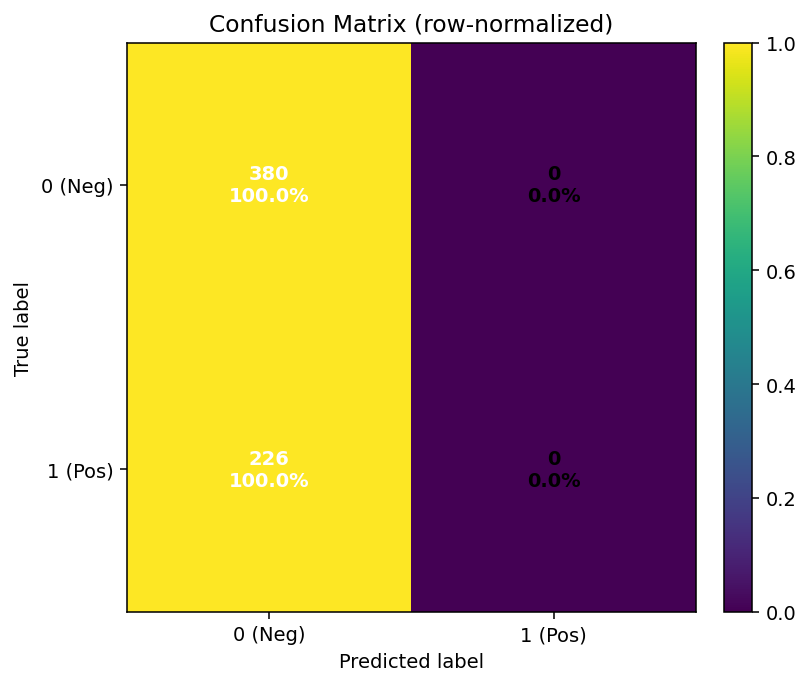

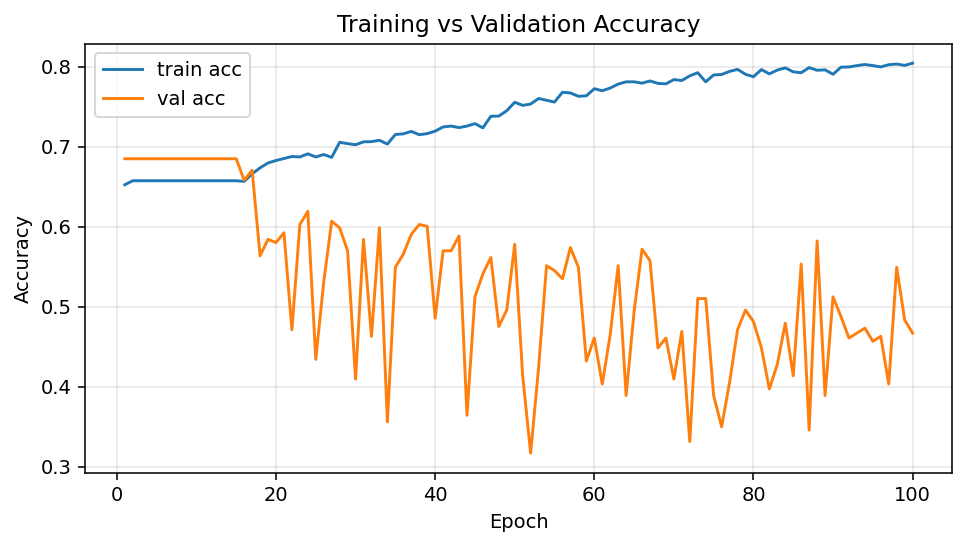

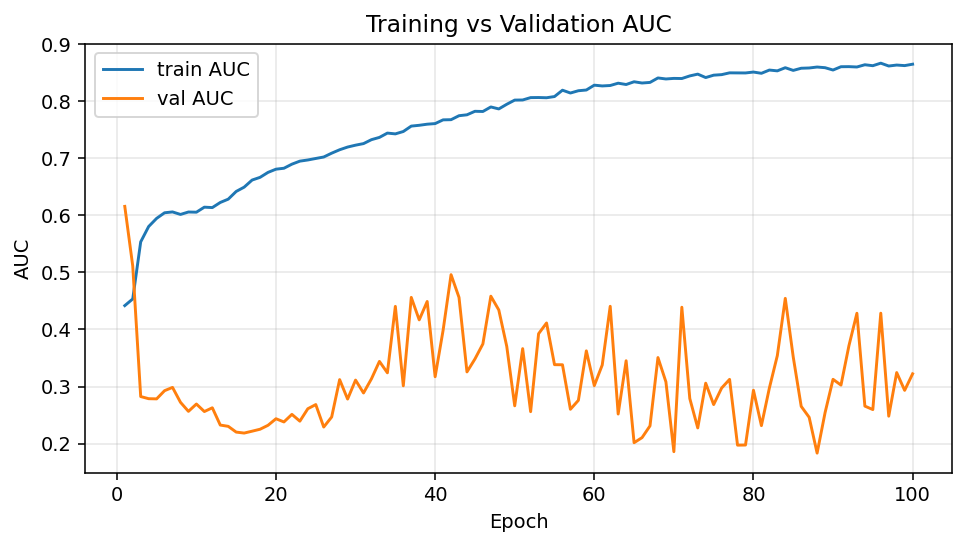

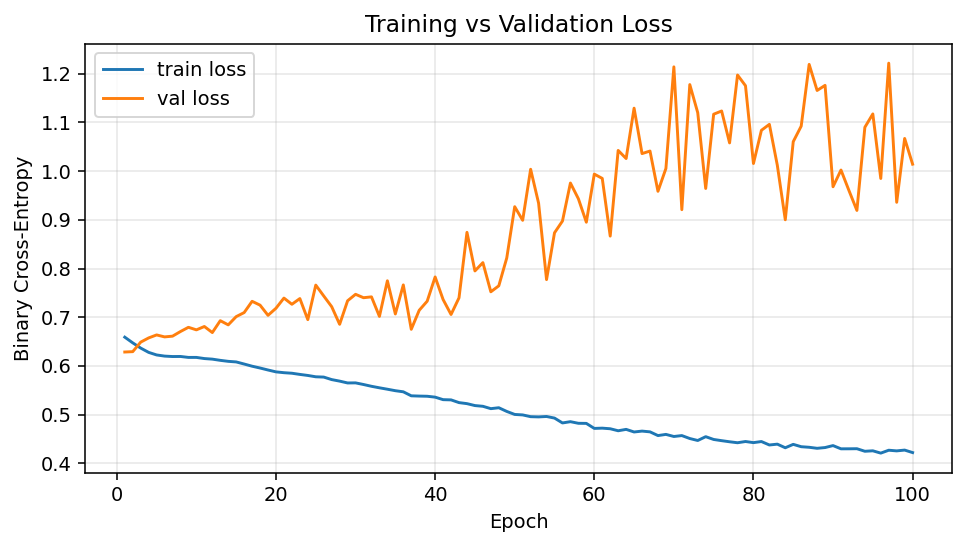

In [4]:
# === Pretty confusion matrix + training curves ===
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# ----- Confusion matrix (counts + percentages) -----
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

labels = ["0 (Neg)", "1 (Pos)"]
fig_cm, ax = plt.subplots(figsize=(6, 5), dpi=140)
im = ax.imshow(cm_norm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# ticks & labels
ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    xlabel="Predicted label",
    ylabel="True label",
    title="Confusion Matrix (row-normalized)"
)

plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

# annotate each cell with "count\nxx.x%"
thresh = cm_norm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            f"{cm[i, j]}\n{cm_norm[i, j]*100:.1f}%",
            ha="center", va="center",
            color="white" if cm_norm[i, j] > thresh else "black",
            fontsize=10, fontweight="bold"
        )

fig_cm.tight_layout()
plt.show()

# Optionally save:
# fig_cm.savefig("confusion_matrix_pretty.png", bbox_inches="tight", dpi=200)

# ----- Keras history plots: acc, AUC, loss -----
hist = history.history
epochs = np.arange(1, len(hist.get("loss", [])) + 1)

# Some codebases use different metric keys; handle both.
acc_key     = "acc"     if "acc"     in hist else "accuracy"
val_acc_key = "val_acc" if "val_acc" in hist else "val_accuracy"
auc_key     = "auc"
val_auc_key = "val_auc"

# 1) Accuracy
fig1, ax1 = plt.subplots(figsize=(7, 4), dpi=140)
ax1.plot(epochs, hist[acc_key],     label="train acc")
ax1.plot(epochs, hist[val_acc_key], label="val acc")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Training vs Validation Accuracy")
ax1.grid(True, alpha=0.3)
ax1.legend()
fig1.tight_layout()
plt.show()
# fig1.savefig("history_accuracy.png", bbox_inches="tight", dpi=200)

# 2) AUC (if present)
if auc_key in hist and val_auc_key in hist:
    fig2, ax2 = plt.subplots(figsize=(7, 4), dpi=140)
    ax2.plot(epochs, hist[auc_key],     label="train AUC")
    ax2.plot(epochs, hist[val_auc_key], label="val AUC")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("AUC")
    ax2.set_title("Training vs Validation AUC")
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    fig2.tight_layout()
    plt.show()
    # fig2.savefig("history_auc.png", bbox_inches="tight", dpi=200)

# 3) Loss
if "loss" in hist and "val_loss" in hist:
    fig3, ax3 = plt.subplots(figsize=(7, 4), dpi=140)
    ax3.plot(epochs, hist["loss"],     label="train loss")
    ax3.plot(epochs, hist["val_loss"], label="val loss")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Binary Cross-Entropy")
    ax3.set_title("Training vs Validation Loss")
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    fig3.tight_layout()
    plt.show()

In [5]:
# --- Dataset sizes + class counts ---
def split_summary(name, files):
    n = len(files)
    ys = np.array([label_for_file(p) for p in files], dtype=int)
    n_pos = int((ys == 1).sum())
    n_neg = int((ys == 0).sum())
    print(f"{name:>6} size: {n:5d}  |  pos: {n_pos:4d}  neg: {n_neg:4d}  "
          f"|  pos%: {100.0 * n_pos / max(1, n):5.1f}")

print("\n--- Split summary ---")
split_summary("train", train_files)
split_summary("val",   val_files)
split_summary("test",  test_files)
print("---------------------\n")


--- Split summary ---
 train size:  3596  |  pos: 1231  neg: 2365  |  pos%:  34.2
   val size:   486  |  pos:  153  neg:  333  |  pos%:  31.5
  test size:   606  |  pos:  226  neg:  380  |  pos%:  37.3
---------------------



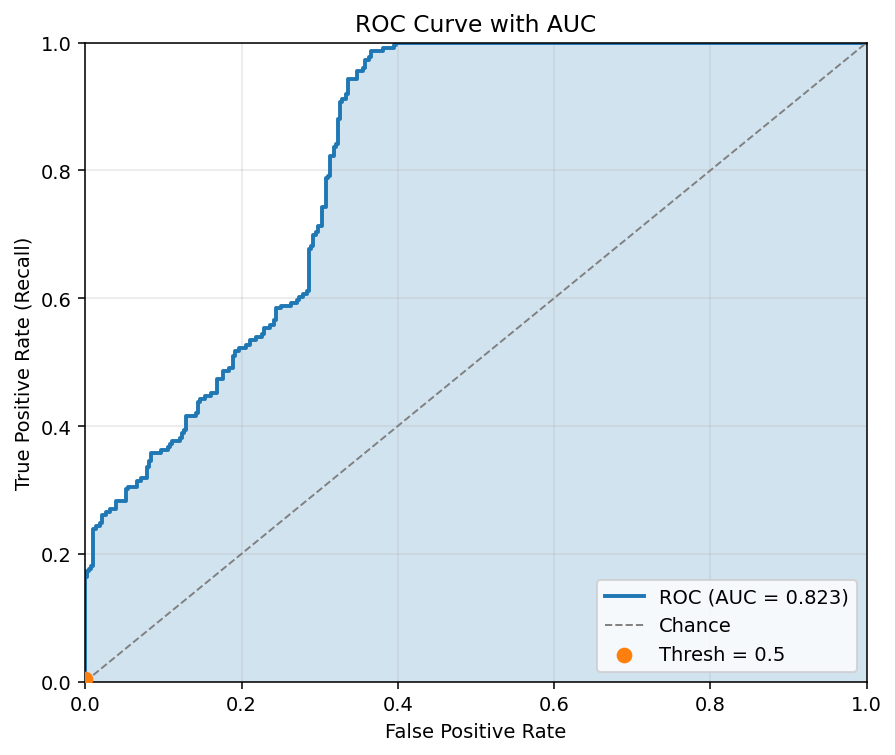

In [6]:
# --- ROC curve with shaded AUC and the 0.5-threshold operating point ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC
fpr, tpr, thr = roc_curve(y_true, probs1)
roc_auc = roc_auc_score(y_true, probs1)

# Find the point closest to threshold = 0.5 (for marking current operating point)
idx_05 = np.argmin(np.abs(thr - 0.5)) if len(thr) else None

plt.figure(figsize=(6.5, 5.5), dpi=140)
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {roc_auc:.3f})")
plt.fill_between(fpr, tpr, step="pre", alpha=0.2)

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color="gray", label="Chance")

# Mark operating point at threshold 0.5
if idx_05 is not None and 0 <= idx_05 < len(fpr):
    plt.scatter([fpr[idx_05]], [tpr[idx_05]], s=50, zorder=3, label="Thresh = 0.5")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve with AUC")
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

AUC = 0.822869
Youden best threshold     : 0.375559360
Min distance ROC threshold: 0.376493633
Best-F1 threshold         : 0.375559360

Using threshold = 0.375559360
Confusion matrix (raw counts):
 [[241 139]
 [  3 223]]

Classification report:
               precision    recall  f1-score   support

           0      0.988     0.634     0.772       380
           1      0.616     0.987     0.759       226

    accuracy                          0.766       606
   macro avg      0.802     0.810     0.765       606
weighted avg      0.849     0.766     0.767       606

Accuracy: 0.7656765676567657
F1 score: 0.7585034013605442


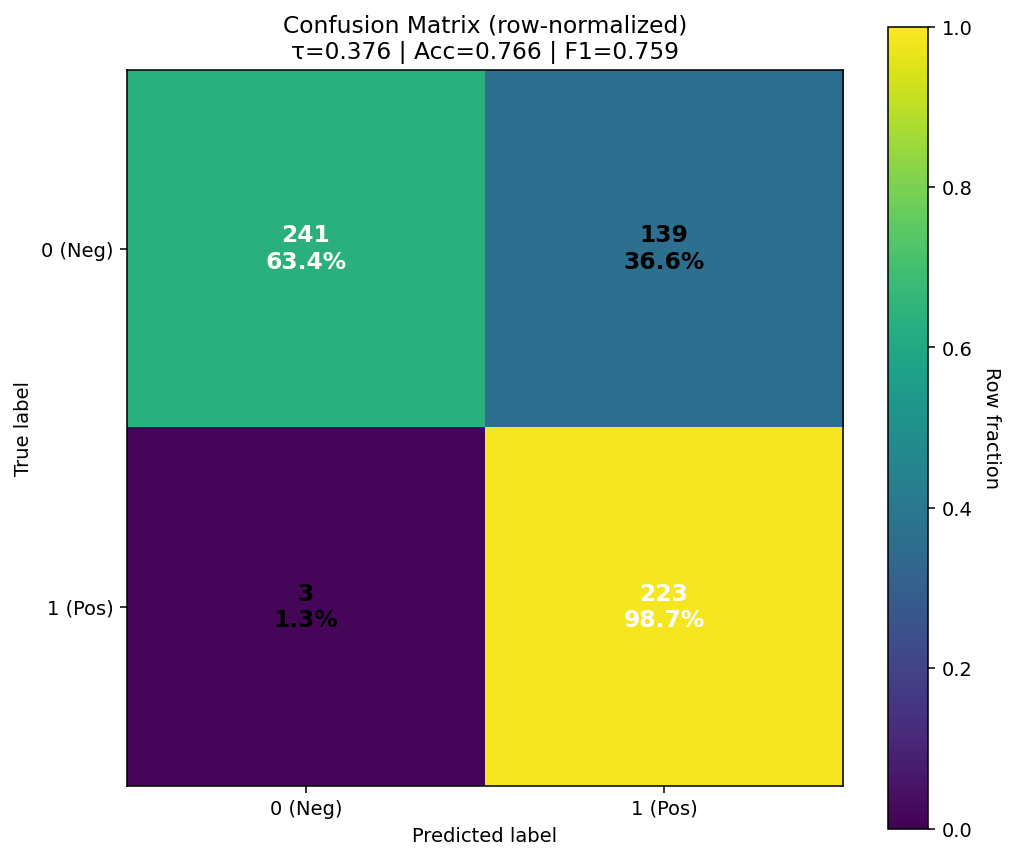

In [7]:
import numpy as np
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, f1_score,
    confusion_matrix, classification_report, accuracy_score
)
import matplotlib.pyplot as plt

# --- ROC-based stats (unchanged) ---
fpr, tpr, thr = roc_curve(y_true, probs1)
roc_auc = roc_auc_score(y_true, probs1)

# thresholds can include +inf; ignore it for picking cutpoints
mask = ~np.isinf(thr)
fpr_m, tpr_m, thr_m = fpr[mask], tpr[mask], thr[mask]

# 1) Youden's J
youden_idx = np.argmax(tpr_m - fpr_m)
thr_youden = float(thr_m[youden_idx])

# 2) Minimum distance to (0,1) on ROC
dist = np.sqrt((1.0 - tpr_m)**2 + (fpr_m**2))
minD_idx = np.argmin(dist)
thr_minD = float(thr_m[minD_idx])

# 3) Best F1 via precision-recall curve thresholds
prec, rec, thr_pr = precision_recall_curve(y_true, probs1)
f1_vals = 2 * prec[:-1] * rec[:-1] / np.clip(prec[:-1] + rec[:-1], 1e-12, None)
f1_idx = np.argmax(f1_vals)
thr_f1 = float(thr_pr[f1_idx])

print(f"AUC = {roc_auc:.6f}")
print(f"Youden best threshold     : {thr_youden:.9f}")
print(f"Min distance ROC threshold: {thr_minD:.9f}")
print(f"Best-F1 threshold         : {thr_f1:.9f}")

# --- Pick which to use (choose one) ---
thr_best = thr_youden     # or thr_minD, or thr_f1

# Apply threshold and report metrics
y_pred_best = (probs1 >= thr_best).astype(int)

print(f"\nUsing threshold = {thr_best:.9f}")
print("Confusion matrix (raw counts):\n", confusion_matrix(y_true, y_pred_best, labels=[0,1]))
print("\nClassification report:\n", classification_report(y_true, y_pred_best, digits=3))
print("Accuracy:", accuracy_score(y_true, y_pred_best))
print("F1 score:", f1_score(y_true, y_pred_best))

# --- Plot confusion matrix like your example (row-normalized) ---
labels = [0, 1]
cm = confusion_matrix(y_true, y_pred_best, labels=labels)

# row-normalize with safe divide
row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums != 0)

fig, ax = plt.subplots(figsize=(7.5, 6.5), dpi=140)
im = ax.imshow(cm_norm, cmap='viridis', vmin=0, vmax=1)

# annotate: counts (line 1) + percent (line 2)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm_norm[i, j]
        txt_color = 'white' if val > 0.5 else 'black'
        ax.text(j, i, f"{cm[i, j]:d}\n{val*100:.1f}%", ha='center', va='center',
                fontsize=12, fontweight='bold', color=txt_color)

ax.set_xticks([0,1], ['0 (Neg)', '1 (Pos)'])
ax.set_yticks([0,1], ['0 (Neg)', '1 (Pos)'])
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Confusion Matrix (row-normalized)\n"
             f"τ={thr_best:.3f} | Acc={accuracy_score(y_true, y_pred_best):.3f} | F1={f1_score(y_true, y_pred_best):.3f}")

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Row fraction', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()
